In [1]:
import numpy as np
import pickle
import nibabel as nib
import os

In [2]:
preprocessed_folder = "/home/bryan/data/mbas_nnUNet_preprocessed/Dataset101_MBAS/MedNeXtPlans_3d_fullres"

In [20]:
subject_id = "MBAS_001"

npy = np.load(os.path.join(preprocessed_folder, f"{subject_id}.npy"))
npz = np.load(os.path.join(preprocessed_folder, f"{subject_id}.npz"))
with open(os.path.join(preprocessed_folder, f"{subject_id}.pkl"), "rb") as f:
    pkl = pickle.load(f)
seg_npy = np.load(os.path.join(preprocessed_folder, f"{subject_id}_seg.npy"))

In [21]:
def print_tensor(tensor, name, force_unique=False):
    print(name, tensor.shape, tensor.dtype)
    if tensor.dtype == np.float32:
        print(f"\trange: [{tensor.min()}, {tensor.max()}]")
    elif tensor.dtype in (np.int8, np.uint8) or force_unique:
        print(f"\t{np.unique(tensor.flatten(), return_counts=True)}")
        

print_tensor(npy, "npy")
print_tensor(seg_npy, "seg_npy")
print_tensor(npz["data"], "cropped npz[data]")
print_tensor(npz["seg"], "cropped npz[seg]")

npy (1, 44, 638, 638) float32
	range: [-0.6321948766708374, 9.467267036437988]
seg_npy (1, 44, 638, 638) int8
	(array([-1,  0,  1,  2,  3], dtype=int8), array([  660988, 16951668,    68342,   126532,   102406]))
cropped npz[data] (1, 44, 638, 638) float32
	range: [-0.6321948766708374, 9.467267036437988]
cropped npz[seg] (1, 44, 638, 638) int8
	(array([-1,  0,  1,  2,  3], dtype=int8), array([  660988, 16951668,    68342,   126532,   102406]))


In [22]:
pkl

{'sitk_stuff': {'spacing': (0.625, 0.625, 2.5),
  'origin': (-190.72938537597656, -180.62953186035156, -26.63135528564453),
  'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)},
 'spacing': [2.5, 0.625, 0.625],
 'shape_before_cropping': (44, 640, 640),
 'bbox_used_for_cropping': [[0, 44], [1, 639], [1, 639]],
 'shape_after_cropping_and_before_resampling': (44, 638, 638),
 'class_locations': {1: array([[  0,  11, 284, 255],
         [  0,  25, 288, 289],
         [  0,   4, 270, 269],
         ...,
         [  0,  15, 345, 382],
         [  0,  20, 287, 255],
         [  0,   4, 239, 270]]),
  2: array([[  0,   7, 226, 297],
         [  0,   3, 323, 274],
         [  0,   9, 211, 295],
         ...,
         [  0,  12, 224, 308],
         [  0,  16, 243, 298],
         [  0,  10, 246, 270]]),
  3: array([[  0,  25, 332, 385],
         [  0,  25, 309, 327],
         [  0,  32, 337, 363],
         ...,
         [  0,  15, 318, 384],
         [  0,  31, 332, 338],
         [  0,  

In [23]:
# folder_with_segs_from_previous_stage should contain .npz files

In [24]:
# Example item from folder_with_segs_from_previous_stage
prev_npz = np.load("/home/bryan/expr/nnUNet_results/Dataset101_MBAS/nnUNetTrainer_250epochs__nnUNetPlans__3d_cascade_fullres_from_only_atrium/predicted_next_stage/3d_cascade_fullres_from_only_atrium/MBAS_001.npz")

# Example validation output prediction
prev_val_gz = nib.load("/home/bryan/expr/nnUNet_results/Dataset101_MBAS/nnUNetTrainer_250epochs__nnUNetPlans__3d_cascade_fullres_from_only_atrium/fold_2/validation/MBAS_001.nii.gz")
prev_val_gz = prev_val_gz.get_fdata()

In [25]:
# Seg from prev stage should be cropped
print_tensor(prev_npz["seg"], "seg_from_prev_stage")
print_tensor(prev_val_gz, "val predictions", force_unique=True)

seg_from_prev_stage (44, 638, 638) uint8
	(array([0, 1, 2, 3], dtype=uint8), array([17606737,    74050,   121484,   107665]))
val predictions (640, 640, 44) float64
	(array([0., 1., 2., 3.]), array([17719201,    74050,   121484,   107665]))


In [26]:
from acvl_utils.cropping_and_padding.bounding_boxes import bounding_box_to_slice


prediction_trans = prev_val_gz.astype(np.uint8).transpose([2,1,0])
bbox_used_for_cropping = pkl["bbox_used_for_cropping"]
slicer = bounding_box_to_slice(bbox_used_for_cropping)
prediction_cropped = prediction_trans[slicer]

In [27]:
prediction_cropped.shape

(44, 638, 638)

In [28]:
prev_npz["seg"].shape

(44, 638, 638)

In [29]:
np.allclose(
    prediction_cropped,
    prev_npz["seg"]
)

True

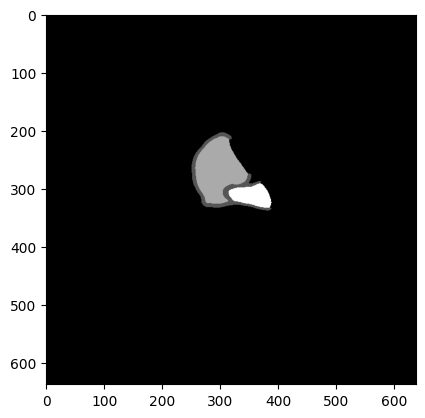

In [30]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(prediction_cropped[10], cmap="gray")

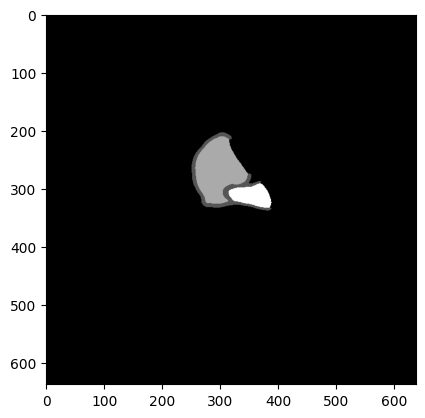

In [31]:
plt.imshow(prev_npz["seg"][10], cmap="gray")

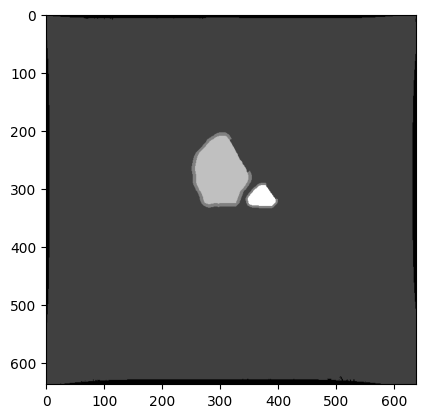

In [40]:
npz["seg"][npz["seg"] < 0] = 0
plt.imshow(npz["seg"][0,10], cmap="gray")

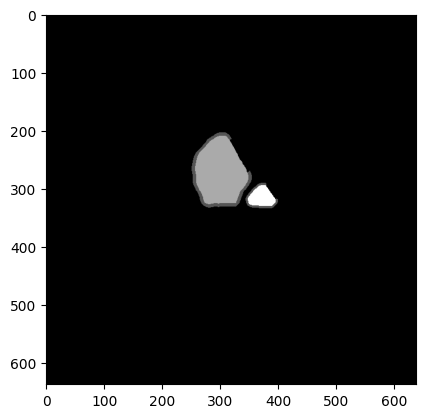

In [45]:
array = npz["seg"]
array[array < 0] = 0
plt.imshow(array[0,10], cmap="gray")

In [47]:
array.shape

(1, 44, 638, 638)

In [48]:
gt_binary_npz = np.load("/home/bryan/expr/mbas_nnUNet_results/Dataset101_MBAS/cascade_ground_truth/ground_truth_binary/MBAS_001.npz")

In [50]:
print_tensor(gt_binary_npz["seg"], "gt_binary_npz[seg]")

gt_binary_npz[seg] (44, 638, 638) int8
	(array([0, 1], dtype=int8), array([17612656,   297280]))


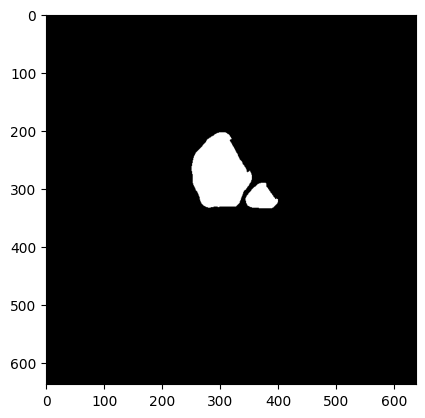

In [51]:
plt.imshow(gt_binary_npz["seg"][10], cmap="gray")